In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
def intercala_listas(lista1,lista2):
    # Assumes lista1 and lista2 are the same length 
    lista = []

    for i in range(len(lista1)):
        lista.append(lista1[i])
        lista.append(lista2[i])

    return lista

In [3]:
# step 1

CANT_ENTRENAMIENTO=50
CANT_PRUEBAS=50
filenames_train = intercala_listas(
    [f'dataset/COVID/images/COVID-{i}.png' for i in range(1, CANT_ENTRENAMIENTO+1)],
    [f'dataset/Normal/images/Normal-{i}.png' for i in range(1, CANT_ENTRENAMIENTO+1)])
labels_train = tf.constant(intercala_listas(
    [1 for i in range(1,CANT_ENTRENAMIENTO+1)],
    [0 for i in range(1,CANT_ENTRENAMIENTO+1)]))

filenames_test = intercala_listas(
    [f'dataset/COVID/images/COVID-{i}.png' for i in range(CANT_ENTRENAMIENTO+1, CANT_ENTRENAMIENTO+CANT_PRUEBAS+1)],
    [f'dataset/Normal/images/Normal-{i}.png' for i in range(CANT_ENTRENAMIENTO+1, CANT_ENTRENAMIENTO+CANT_PRUEBAS+1)])
labels_test = tf.constant(intercala_listas(
    [1 for i in range(1,CANT_PRUEBAS+1)],
    [0 for i in range(1,CANT_PRUEBAS+1)]))

print(filenames_train)
print(labels_train)
# print(filenames_test)
# print(labels_test)

['dataset/COVID/images/COVID-1.png', 'dataset/Normal/images/Normal-1.png', 'dataset/COVID/images/COVID-2.png', 'dataset/Normal/images/Normal-2.png', 'dataset/COVID/images/COVID-3.png', 'dataset/Normal/images/Normal-3.png', 'dataset/COVID/images/COVID-4.png', 'dataset/Normal/images/Normal-4.png', 'dataset/COVID/images/COVID-5.png', 'dataset/Normal/images/Normal-5.png', 'dataset/COVID/images/COVID-6.png', 'dataset/Normal/images/Normal-6.png', 'dataset/COVID/images/COVID-7.png', 'dataset/Normal/images/Normal-7.png', 'dataset/COVID/images/COVID-8.png', 'dataset/Normal/images/Normal-8.png', 'dataset/COVID/images/COVID-9.png', 'dataset/Normal/images/Normal-9.png', 'dataset/COVID/images/COVID-10.png', 'dataset/Normal/images/Normal-10.png', 'dataset/COVID/images/COVID-11.png', 'dataset/Normal/images/Normal-11.png', 'dataset/COVID/images/COVID-12.png', 'dataset/Normal/images/Normal-12.png', 'dataset/COVID/images/COVID-13.png', 'dataset/Normal/images/Normal-13.png', 'dataset/COVID/images/COVID-1

In [4]:
# step 2: create a dataset returning slices of `filenames`
datos_train = tf.data.Dataset.from_tensor_slices((filenames_train, labels_train))
datos_test = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

In [5]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos_train, datos_test
datos_entrenamiento

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [6]:
nombres_clases = ['covid','normal']
nombres_clases


['covid', 'normal']

In [7]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=0)
  image = tf.cast(image_decoded, tf.float32)
  image /= 255 
  return image, label

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(_parse_function)
datos_pruebas = datos_pruebas.map(_parse_function)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

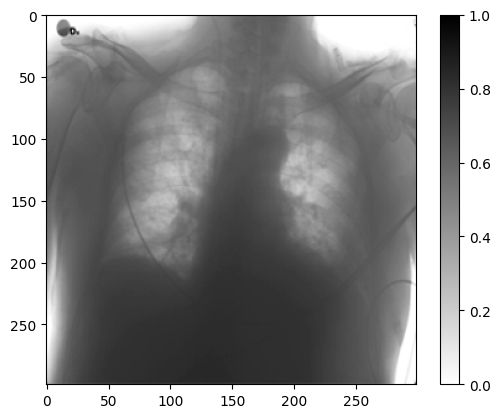

In [8]:
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((299,299)) #Redimensionar, cosas de tensores, lo veremos despues# imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


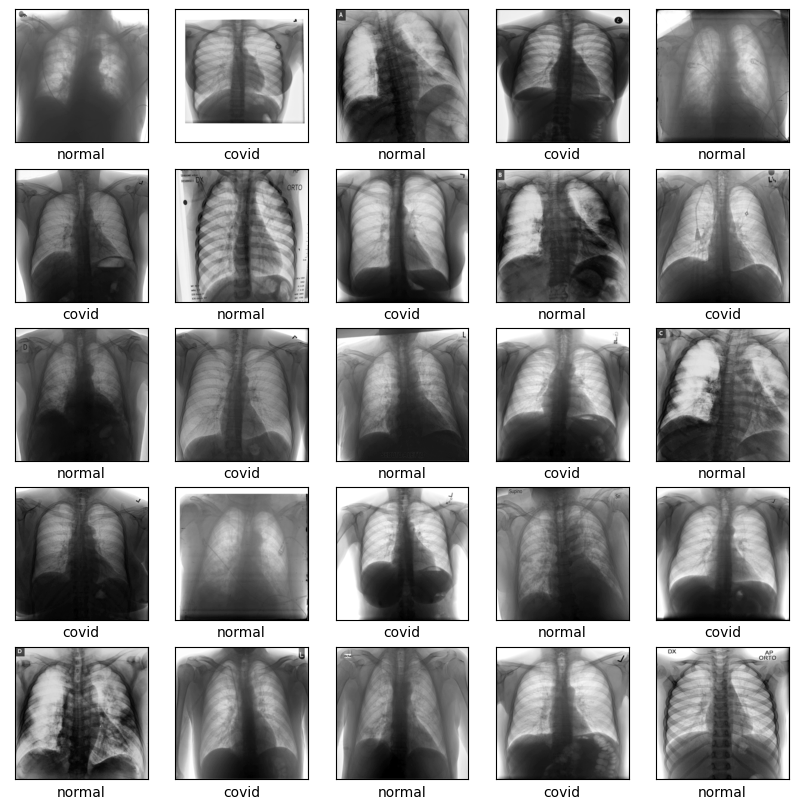

In [9]:
#Dibujar mas
plt.figure(figsize=(10,10))
# for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((299,299))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()


In [10]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(), #1 - blanco y negro
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  #tf.keras.layers.Dense(10, activation=tf.nn.sigmoid) #Para redes de clasificacion
])

In [11]:
# modelo = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(512, activation="sigmoid")
# ])

In [12]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [13]:
# #Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = CANT_ENTRENAMIENTO
num_ej_pruebas = CANT_PRUEBAS

In [14]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

50
50


In [15]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [16]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=10,batch_size=TAMANO_LOTE,validation_data=datos_pruebas, steps_per_epoch= 5,validation_steps=3)

Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 0.6968 - accuracy: 0.4437 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 8s 2s/step - loss: 0.6947 - accuracy: 0.4750 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 9s 2s/step - loss: 0.6939 - accuracy: 0.4875 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 0.6908 - accuracy: 0.5312 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 9s 2s/step - loss: 0.6953 - accuracy: 0.4875 - val_loss: 0.6916 - val_accuracy: 0.6250
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.6898 - accuracy: 0.5125 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 9s 2s/step - loss: 0.6818 - accuracy: 0.5813 - val_loss: 0.6907 - val_accuracy: 0.5208
Epoch 8/10
5/5 [========================

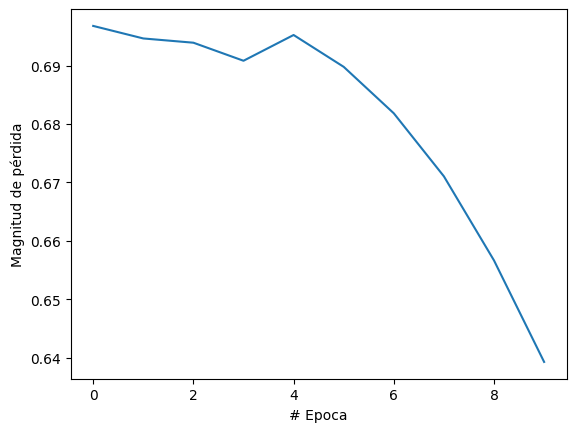

In [17]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 1s 501ms/step


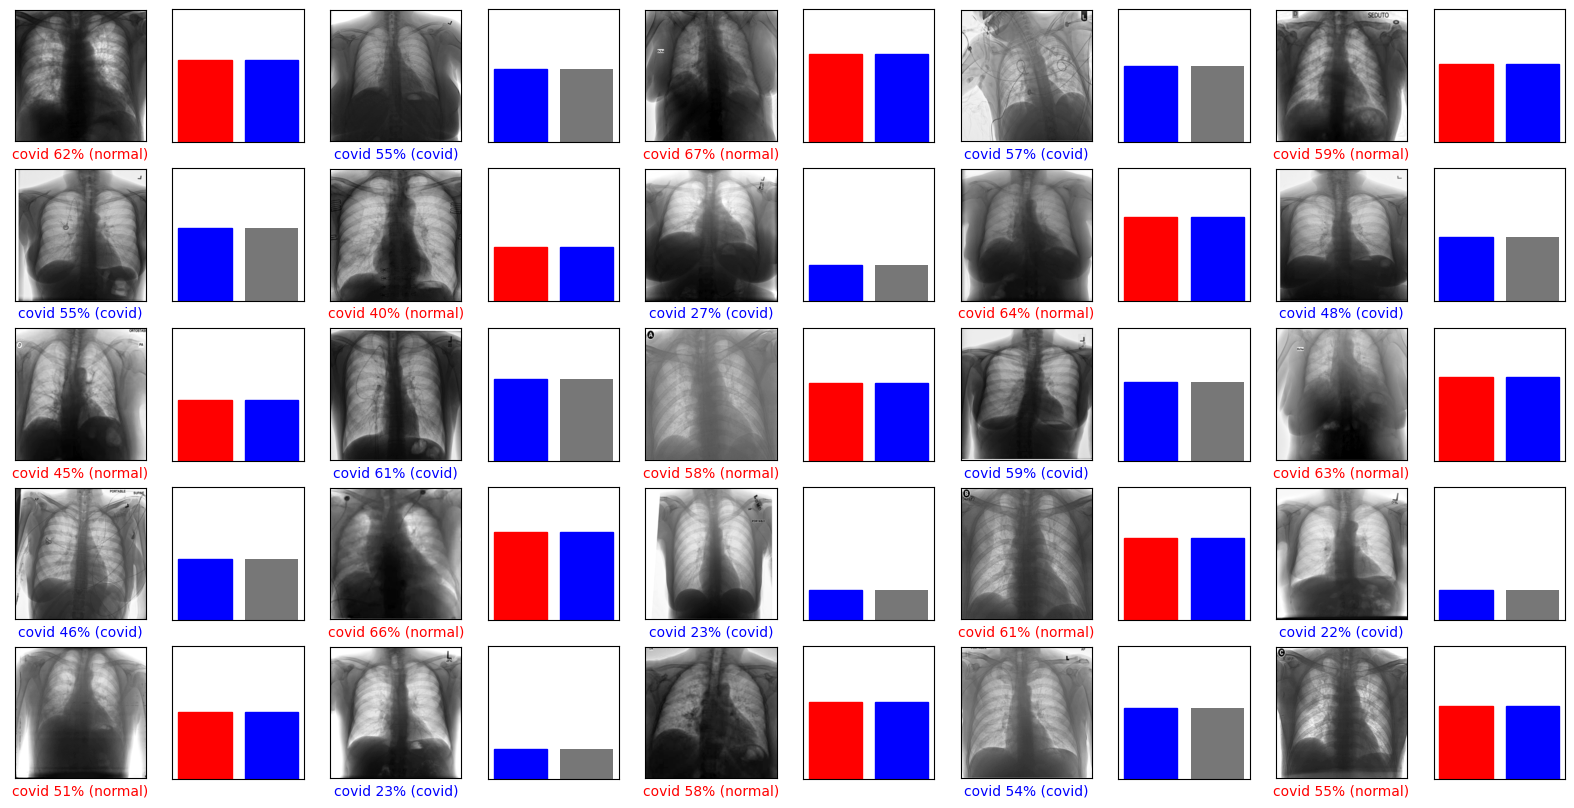

In [18]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(2), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [19]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 140ms/step
Prediccion: covid


In [20]:
#Exportacion del modelo a h5
#modelo.save('modelo_exportado.h5')

In [21]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
# %pip install tensorflowjs

In [22]:
#Convertir el archivo h5 a formato de tensorflowjs
#!mkdir tfjs_target_dir
#!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [23]:
#Veamos si si creo la carpeta
#!ls

In [24]:
#Veamos el contenido de la carpeta
#!ls tfjs_target_dir